# Fine-Tune a Generative AI Model for Text Summarization

In this notebook, we will fine-tune an existing LLM from Hugging Face for enhanced text summarization. You will use the [FLAN-T5](https://huggingface.co/docs/transformers/model_doc/flan-t5) model, which provides a high quality instruction tuned model and can summarize text out of the box. To improve the inferences, we will explore a full fine-tuning approach and evaluate the results with ROUGE metrics. Then you will perform Parameter Efficient Fine-Tuning (PEFT), evaluate the resulting model and see that the benefits of PEFT outweigh the slightly-lower performance metrics.

# Table of Contents

<a name='1.1'></a>
### 1.1 - Set up Kernel and Required Dependencies

In [1]:
%pip install -U datasets==2.17.0

%pip install --upgrade pip
%pip install --disable-pip-version-check \
    torch==1.13.1 \
    torchdata==0.5.1 --quiet

%pip install \
    transformers==4.27.2 \
    evaluate==0.4.0 \
    rouge_score==0.1.2 \
    loralib==0.1.1 \
    peft==0.3.0 --quiet

INFO: pip is looking at multiple versions of multiprocess to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 536.6/536.6 kB 10.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.4/166.4 kB 14.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 11.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 15.6 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2023.10.0 which is incompatible.
   ━━━━━━━

In [2]:
#Now installing necessary packages and libraries for llm

%pip install -U datasets==2.17.0
%pip install --disable-pip-version-check \
             torch==1.13.1 \
             torchdata==0.5.1 --quiet

%pip install \
     transformers==4.27.2 \
     evaluate==0.4.0 \
     rouge_score==0.1.2 \
     loralib==0.1.1 \
     peft==0.3.0 --quiet

In [3]:
from datasets import load_dataset
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer, GenerationConfig, TrainingArguments, Trainer
import torch
import time
import evaluate
import pandas as pd
import numpy as np

In [4]:
#Now importing necessary components from the library
from datasets import load_dataset
from transformers import AutoModelForSeq2SeqLM,AutoTokenizer, GenerationConfig, TrainingArguments, Trainer
import torch
import time
import evaluate
import pandas as pd
import numpy as np

<a name='1.2'></a>
#  Loading  Dataset and LLM

we are going to continue experimenting with the [DialogSum](https://huggingface.co/datasets/knkarthick/dialogsum) Hugging Face dataset. It contains 10,000+ dialogues with the corresponding manually labeled summaries and topics.

In [5]:
huggingface_dataset_name = "knkarthick/dialogsum"

dataset = load_dataset(huggingface_dataset_name)

dataset

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split: 0 examples [00:00, ? examples/s]

/usr/local/lib/python3.10/dist-packages/datasets/download/streaming_download_manager.py:784: FutureWarning: The 'verbose' keyword in pd.read_csv is deprecated and will be removed in a future version.
  return pd.read_csv(xopen(filepath_or_buffer, "rb", download_config=download_config), **kwargs)


Generating validation split: 0 examples [00:00, ? examples/s]

/usr/local/lib/python3.10/dist-packages/datasets/download/streaming_download_manager.py:784: FutureWarning: The 'verbose' keyword in pd.read_csv is deprecated and will be removed in a future version.
  return pd.read_csv(xopen(filepath_or_buffer, "rb", download_config=download_config), **kwargs)


Generating test split: 0 examples [00:00, ? examples/s]

/usr/local/lib/python3.10/dist-packages/datasets/download/streaming_download_manager.py:784: FutureWarning: The 'verbose' keyword in pd.read_csv is deprecated and will be removed in a future version.
  return pd.read_csv(xopen(filepath_or_buffer, "rb", download_config=download_config), **kwargs)


DatasetDict({
    train: Dataset({
        features: ['id', 'dialogue', 'summary', 'topic'],
        num_rows: 12460
    })
    validation: Dataset({
        features: ['id', 'dialogue', 'summary', 'topic'],
        num_rows: 500
    })
    test: Dataset({
        features: ['id', 'dialogue', 'summary', 'topic'],
        num_rows: 1500
    })
})

In [6]:
#Now loading the same text summarization dataset as in the previous case
hug_dataset_name='knkarthick/dialogsum'
#Now loading dataset
dataset=load_dataset(hug_dataset_name)

dataset

DatasetDict({
    train: Dataset({
        features: ['id', 'dialogue', 'summary', 'topic'],
        num_rows: 12460
    })
    validation: Dataset({
        features: ['id', 'dialogue', 'summary', 'topic'],
        num_rows: 500
    })
    test: Dataset({
        features: ['id', 'dialogue', 'summary', 'topic'],
        num_rows: 1500
    })
})

Load the pre-trained [FLAN-T5 model](https://huggingface.co/docs/transformers/model_doc/flan-t5) and its tokenizer directly from HuggingFace. Notice that we will be using the [small version](https://huggingface.co/google/flan-t5-base) of FLAN-T5. Setting `torch_dtype=torch.bfloat16` specifies the memory type to be used by this model.

In [7]:
model_name='google/flan-t5-base'

original_model = AutoModelForSeq2SeqLM.from_pretrained(model_name, torch_dtype=torch.bfloat16)
tokenizer = AutoTokenizer.from_pretrained(model_name)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:797: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/1.40k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/990M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/2.54k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.42M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/2.20k [00:00<?, ?B/s]

In [8]:
#Now model will be loaded
model_name='google/flan-t5-base'
#Now loading the model
org_model=AutoModelForSeq2SeqLM.from_pretrained(model_name,torch_dtype=torch.bfloat16)
#Now importing the tokenizer
tokenizer=AutoTokenizer.from_pretrained(model_name)

**Printing the number of trainable parameters**

In [9]:
def print_number_of_trainable_model_parameters(model):
    trainable_model_params = 0
    all_model_params = 0
    for _, param in model.named_parameters():
        all_model_params += param.numel()
        if param.requires_grad:
            trainable_model_params += param.numel()
    return f"trainable model parameters: {trainable_model_params}\nall model parameters: {all_model_params}\npercentage of trainable model parameters: {100 * trainable_model_params / all_model_params:.2f}%"

print(print_number_of_trainable_model_parameters(original_model))

trainable model parameters: 247577856
all model parameters: 247577856
percentage of trainable model parameters: 100.00%


In [10]:
#Now writing a function for pulling and printing out the number of parameters
def print_num_trainable_params_(model):
    trainable_params=0
    all_params=0
    for _,params in model.named_parameters():
        all_params+=params.numel() #something .numel() in pytorch returns total number of all elements
        if params.requires_grad:
            trainable_params+=params.numel()
    return f"Number of Trainable Parameters {trainable_params} \n where total  model parameter number is {all_params} "


print(print_num_trainable_params_(org_model))

Number of Trainable Parameters 247577856 
 where total  model parameter number is 247577856 


<a name='1.3'></a>
### 1.3 - Zero Shot Inferencing

Test the model with the zero shot inferencing. we can see that the model struggles to summarize the text compared to the baseline summary, but it does pull out some important information from the text which indicates the model can be fine-tuned to the task at hand.

In [11]:
index = 200

dialogue = dataset['test'][index]['dialogue']
summary = dataset['test'][index]['summary']

prompt = f"""
Summarize the following conversation.

{dialogue}

Summary:
"""

inputs = tokenizer(prompt, return_tensors='pt')
output = tokenizer.decode(
    original_model.generate(
        inputs["input_ids"],
        max_new_tokens=200,
    )[0],
    skip_special_tokens=True
)

dash_line = '-'.join('' for x in range(100))
print(dash_line)
print(f'INPUT PROMPT:\n{prompt}')
print(dash_line)
print(f'BASELINE HUMAN SUMMARY:\n{summary}\n')
print(dash_line)
print(f'MODEL GENERATION - ZERO SHOT:\n{output}')

---------------------------------------------------------------------------------------------------
INPUT PROMPT:

Summarize the following conversation.

#Person1#: Have you considered upgrading your system?
#Person2#: Yes, but I'm not sure what exactly I would need.
#Person1#: You could consider adding a painting program to your software. It would allow you to make up your own flyers and banners for advertising.
#Person2#: That would be a definite bonus.
#Person1#: You might also want to upgrade your hardware because it is pretty outdated now.
#Person2#: How can we do that?
#Person1#: You'd probably need a faster processor, to begin with. And you also need a more powerful hard disc, more memory and a faster modem. Do you have a CD-ROM drive?
#Person2#: No.
#Person1#: Then you might want to add a CD-ROM drive too, because most new software programs are coming out on Cds.
#Person2#: That sounds great. Thanks.

Summary:

-------------------------------------------------------------------

In [12]:
#Testing with zero shot inference first which brings myself to write a function

def generate_output(llm_model,prompt,max_token=200):
    encoded_seq=tokenizer(prompt,return_tensors='pt')
    encoded_out=llm_model.generate(encoded_seq['input_ids'],max_new_tokens=max_token)[0]
    decoded_out=tokenizer.decode(encoded_out,skip_special_tokens=True)

    return decoded_out

dashline='-'.join('' for x in range(200))

In [13]:
index=119
dialogue=dataset['test'][index]['dialogue']
summary=dataset['test'][index]['summary']

prompt=f"""Summarize the following conversation.

{dialogue}

summary:
"""

#model summary
model_summary=generate_output(org_model,prompt)

print(dashline)
print(dashline)
print(f'INPUT PROMPT:\n{prompt}')
print(dashline)
print(f'BASELINE HUMAN SUMMARY:\n{summary}\n')
print(dashline)
print(f'MODEL GENERATION - ZERO SHOT:\n{model_summary}')

-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
INPUT PROMPT:
Summarize the following conversation.

#Person1#: Come in, come in! Can I help you?
#Person2#: Professor Turner, are you giving your Advanced Geology course again next semester?
#Person1#: Yes.
#Person2#: I wonder if I could enroll in it, I know it's a graduate course and I'm only a junior, but...
#Person1#: Aren't you a bit young? I've allowed qualified seniors to take the course and they usually have a hard time to keep up.
#Person2#: I know, but the geology of the American West is my favorite interest and I've read a lot in the field. Last semester I took Professor Burman's co

<a name='2'></a>
## Perform Full Fine-Tuning

<a name='2.1'></a>
### 2.1 - Preprocess the Dialog-Summary Dataset

We need to convert the dialog-summary (prompt-response) pairs into explicit instructions for the LLM. Prepend an instruction to the start of the dialog with `Summarize the following conversation` and to the start of the summary with `Summary` as follows:

Training prompt (dialogue):
```
Summarize the following conversation.

    Chris: This is his part of the conversation.
    Antje: This is her part of the conversation.
    
Summary:
```

Training response (summary):
```
Both Chris and Antje participated in the conversation.
```

Then preprocess the prompt-response dataset into tokens and pull out their `input_ids` (1 per token).

In [14]:
def tokenize_function(example):
    start_prompt = 'Summarize the following conversation.\n\n'
    end_prompt = '\n\nSummary: '
    prompt = [start_prompt + dialogue + end_prompt for dialogue in example["dialogue"]]
    example['input_ids'] = tokenizer(prompt, padding="max_length", truncation=True, return_tensors="pt").input_ids
    example['labels'] = tokenizer(example["summary"], padding="max_length", truncation=True, return_tensors="pt").input_ids

    return example

# The dataset actually contains 3 diff splits: train, validation, test.
# The tokenize_function code is handling all data across all splits in batches.
tokenized_datasets = dataset.map(tokenize_function, batched=True)
tokenized_datasets = tokenized_datasets.remove_columns(['id', 'topic', 'dialogue', 'summary',])

Map:   0%|          | 0/12460 [00:00<?, ? examples/s]

Map:   0%|          | 0/500 [00:00<?, ? examples/s]

Map:   0%|          | 0/1500 [00:00<?, ? examples/s]

In [ ]:
#Here preprocessing is required for making the dataset comparable for

To save some time in the lab, you will subsample the dataset:

In [15]:
tokenized_datasets = tokenized_datasets.filter(lambda example, index: index % 100 == 0, with_indices=True)

Filter:   0%|          | 0/12460 [00:00<?, ? examples/s]

Filter:   0%|          | 0/500 [00:00<?, ? examples/s]

Filter:   0%|          | 0/1500 [00:00<?, ? examples/s]

Check the shapes of all three parts of the dataset:

In [15]:
print(f"Shapes of the datasets:")
print(f"Training: {tokenized_datasets['train'].shape}")
print(f"Validation: {tokenized_datasets['validation'].shape}")
print(f"Test: {tokenized_datasets['test'].shape}")

print(tokenized_datasets)

Shapes of the datasets:
Training: (12460, 2)
Validation: (500, 2)
Test: (1500, 2)
DatasetDict({
    train: Dataset({
        features: ['input_ids', 'labels'],
        num_rows: 12460
    })
    validation: Dataset({
        features: ['input_ids', 'labels'],
        num_rows: 500
    })
    test: Dataset({
        features: ['input_ids', 'labels'],
        num_rows: 1500
    })
})


The output dataset is ready for fine-tuning.

<a name='2.2'></a>
### 2.2 - Fine-Tune the Model with the Preprocessed Dataset

Now utilize the built-in Hugging Face `Trainer` class (see the documentation [here](https://huggingface.co/docs/transformers/main_classes/trainer)). Pass the preprocessed dataset with reference to the original model. Other training parameters are found experimentally and there is no need to go into details about those at the moment.

In [19]:
output_dir = f'./dialogue-summary-training-{str(int(time.time()))}'

training_args = TrainingArguments(
    output_dir=output_dir,
    learning_rate=1e-5,
    num_train_epochs=1000,
    weight_decay=0.01,
    logging_steps=5,
    max_steps=1000
)

trainer = Trainer(
    model=original_model,
    args=training_args,
    train_dataset=tokenized_datasets['train'],
    eval_dataset=tokenized_datasets['validation']
)

Start training process...



In [20]:
trainer.train()

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss
5,46.650000
10,46.150000
15,46.450000
20,45.200000
25,46.250000
30,45.350000
35,45.350000
40,44.550000
45,44.800000
50,43.750000


TrainOutput(global_step=1000, training_loss=37.70025, metrics={'train_runtime': 217.6978, 'train_samples_per_second': 36.748, 'train_steps_per_second': 4.594, 'total_flos': 5478058819584000.0, 'train_loss': 37.70025, 'epoch': 0.64})

The size of the instruct model is approximately 1GB.

In [21]:
full_model_path="./full-dialogue-summary-checkpoint-local"

trainer.model.save_pretrained(full_model_path)
tokenizer.save_pretrained(full_model_path)

('./full-dialogue-summary-checkpoint-local/tokenizer_config.json',
 './full-dialogue-summary-checkpoint-local/special_tokens_map.json',
 './full-dialogue-summary-checkpoint-local/spiece.model',
 './full-dialogue-summary-checkpoint-local/added_tokens.json',
 './full-dialogue-summary-checkpoint-local/tokenizer.json')

Create an instance of the `AutoModelForSeq2SeqLM` class for the instruct model:

In [22]:
instruct_model = AutoModelForSeq2SeqLM.from_pretrained("./full-dialogue-summary-checkpoint-local", torch_dtype=torch.bfloat16)

<a name='2.3'></a>
### 2.3 - Evaluate the Model Qualitatively (Human Evaluation)

As with many GenAI applications, a qualitative approach where you ask yourself the question "Is my model behaving the way it is supposed to?" is usually a good starting point. In the example below (the same one we started this notebook with), you can see how the fine-tuned model is able to create a reasonable summary of the dialogue compared to the original inability to understand what is being asked of the model.

In [25]:
index = 200
dialogue = dataset['test'][index]['dialogue']
human_baseline_summary = dataset['test'][index]['summary']

prompt = f"""
Summarize the following conversation.

{dialogue}

Summary:
"""

input_ids = tokenizer(prompt, return_tensors="pt").input_ids.to(original_model.device)

original_model_outputs = original_model.generate(input_ids=input_ids, generation_config=GenerationConfig(max_new_tokens=200, num_beams=1))
original_model_text_output = tokenizer.decode(original_model_outputs[0], skip_special_tokens=True)

instruct_model_outputs = instruct_model.generate(input_ids=input_ids.to(instruct_model.device), generation_config=GenerationConfig(max_new_tokens=200, num_beams=1))
instruct_model_text_output = tokenizer.decode(instruct_model_outputs[0], skip_special_tokens=True)

print(dash_line)
print(f'BASELINE HUMAN SUMMARY:\n{human_baseline_summary}')
print(dash_line)
print(f'ORIGINAL MODEL:\n{original_model_text_output}')
print(dash_line)
print(f'INSTRUCT MODEL:\n{instruct_model_text_output}')

---------------------------------------------------------------------------------------------------
BASELINE HUMAN SUMMARY:
#Person1# teaches #Person2# how to upgrade software and hardware in #Person2#'s system.
---------------------------------------------------------------------------------------------------
ORIGINAL MODEL:
#Person1#: Have you considered upgrading your hardware? #Person1#: Yes, but I'm not sure what exactly I want to do.
---------------------------------------------------------------------------------------------------
INSTRUCT MODEL:
You might want to upgrade your computer.


<a name='2.4'></a>
### 2.4 - Evaluate the Model Quantitatively (with ROUGE Metric)

The [ROUGE metric](https://en.wikipedia.org/wiki/ROUGE_(metric)) helps quantify the validity of summarizations produced by models. It compares summarizations to a "baseline" summary which is usually created by a human. While not perfect, it does indicate the overall increase in summarization effectiveness that we have accomplished by fine-tuning.

In [26]:
rouge = evaluate.load('rouge')

Generate the outputs for the sample of the test dataset (only 10 dialogues and summaries to save time), and save the results.

In [28]:
dialogues = dataset['test'][0:10]['dialogue']
human_baseline_summaries = dataset['test'][0:10]['summary']

original_model_summaries = []
instruct_model_summaries = []

for _, dialogue in enumerate(dialogues):
    prompt = f"""
Summarize the following conversation.

{dialogue}

Summary: """
    input_ids = tokenizer(prompt, return_tensors="pt").input_ids.to(original_model.device)

    original_model_outputs = original_model.generate(input_ids=input_ids, generation_config=GenerationConfig(max_new_tokens=200))
    original_model_text_output = tokenizer.decode(original_model_outputs[0], skip_special_tokens=True)
    original_model_summaries.append(original_model_text_output)

    instruct_model_outputs = instruct_model.generate(input_ids=input_ids.to(instruct_model.device), generation_config=GenerationConfig(max_new_tokens=200))
    instruct_model_text_output = tokenizer.decode(instruct_model_outputs[0], skip_special_tokens=True)
    instruct_model_summaries.append(instruct_model_text_output)

zipped_summaries = list(zip(human_baseline_summaries, original_model_summaries, instruct_model_summaries))

df = pd.DataFrame(zipped_summaries, columns = ['human_baseline_summaries', 'original_model_summaries', 'instruct_model_summaries'])
df

,human_baseline_summaries,original_model_summaries,instruct_model_summaries
0,Ms. Dawson helps #Person1# to write a memo to ...,Employees are required to use instant messagin...,This memo is to be distributed to all employee...
1,In order to prevent employees from wasting tim...,Employees will be required to sign a memo requ...,This memo is to be distributed to all employee...
2,Ms. Dawson takes a dictation for #Person1# abo...,The following memos are for employees who are ...,This memo is to be distributed to all employee...
3,#Person2# arrives late because of traffic jam....,#Person1#: I'm so happy to be here. #Person2#:...,Taking public transport to work is a good idea.
4,#Person2# decides to follow #Person1#'s sugges...,The conversation lasted for an hour.,Taking public transport to work is a good idea.
5,#Person2# complains to #Person1# about the tra...,People are talking about the new car.,Taking public transport to work is a good idea.
6,#Person1# tells Kate that Masha and Hero get d...,Masha and Hero are getting divorced.,Masha and Hero are getting divorced.
7,#Person1# tells Kate that Masha and Hero are g...,Masha and Hero are getting divorced.,Masha and Hero are getting divorced.
8,#Person1# and Kate talk about the divorce betw...,Masha and Hero are getting divorced.,Masha and Hero are getting divorced.
9,#Person1# and Brian are at the birthday party ...,Brian's birthday is today.,Brian's birthday is coming up.


Evaluate the models computing ROUGE metrics. Notice the improvement in the results!

In [29]:
original_model_results = rouge.compute(
    predictions=original_model_summaries,
    references=human_baseline_summaries[0:len(original_model_summaries)],
    use_aggregator=True,
    use_stemmer=True,
)

instruct_model_results = rouge.compute(
    predictions=instruct_model_summaries,
    references=human_baseline_summaries[0:len(instruct_model_summaries)],
    use_aggregator=True,
    use_stemmer=True,
)

print('ORIGINAL MODEL:')
print(original_model_results)
print('INSTRUCT MODEL:')
print(instruct_model_results)

ORIGINAL MODEL:
{'rouge1': 0.28202382861650593, 'rouge2': 0.10383408705147837, 'rougeL': 0.23863531459641302, 'rougeLsum': 0.2429800439411423}
INSTRUCT MODEL:
{'rouge1': 0.28647748040489973, 'rouge2': 0.13497482028216662, 'rougeL': 0.23619027925479535, 'rougeLsum': 0.23930701616185485}


The file `data/dialogue-summary-training-results.csv` contains a pre-populated list of all model results which you can use to evaluate on a larger section of data. Let's do that for each of the models:

In [47]:
"""
results = pd.read_csv("data/dialogue-summary-training-results.csv")

human_baseline_summaries = results['human_baseline_summaries'].values
original_model_summaries = results['original_model_summaries'].values
instruct_model_summaries = results['instruct_model_summaries'].values

original_model_results = rouge.compute(
    predictions=original_model_summaries,
    references=human_baseline_summaries[0:len(original_model_summaries)],
    use_aggregator=True,
    use_stemmer=True,
)

instruct_model_results = rouge.compute(
    predictions=instruct_model_summaries,
    references=human_baseline_summaries[0:len(instruct_model_summaries)],
    use_aggregator=True,
    use_stemmer=True,
)

print('ORIGINAL MODEL:')
print(original_model_results)
print('INSTRUCT MODEL:')
print(instruct_model_results)

"""

'\nresults = pd.read_csv("data/dialogue-summary-training-results.csv")\n\nhuman_baseline_summaries = results[\'human_baseline_summaries\'].values\noriginal_model_summaries = results[\'original_model_summaries\'].values\ninstruct_model_summaries = results[\'instruct_model_summaries\'].values\n\noriginal_model_results = rouge.compute(\n    predictions=original_model_summaries,\n    references=human_baseline_summaries[0:len(original_model_summaries)],\n    use_aggregator=True,\n    use_stemmer=True,\n)\n\ninstruct_model_results = rouge.compute(\n    predictions=instruct_model_summaries,\n    references=human_baseline_summaries[0:len(instruct_model_summaries)],\n    use_aggregator=True,\n    use_stemmer=True,\n)\n\nprint(\'ORIGINAL MODEL:\')\nprint(original_model_results)\nprint(\'INSTRUCT MODEL:\')\nprint(instruct_model_results)\n\n'

The results show substantial improvement in all ROUGE metrics:

In [31]:
print("Absolute percentage improvement of INSTRUCT MODEL over ORIGINAL MODEL")

improvement = (np.array(list(instruct_model_results.values())) - np.array(list(original_model_results.values())))
for key, value in zip(instruct_model_results.keys(), improvement):
    print(f'{key}: {value*100:.2f}%')

Absolute percentage improvement of INSTRUCT MODEL over ORIGINAL MODEL
rouge1: 0.45%
rouge2: 3.11%
rougeL: -0.24%
rougeLsum: -0.37%


<a name='3'></a>
## 3 - Perform Parameter Efficient Fine-Tuning (PEFT)

Now, we will  perform **Parameter Efficient Fine-Tuning (PEFT)** fine-tuning as opposed to "full fine-tuning" as we did above. PEFT is a form of instruction fine-tuning that is much more efficient than full fine-tuning - with comparable evaluation results as you will see soon.

PEFT is a generic term that includes **Low-Rank Adaptation (LoRA)** and prompt tuning (which is NOT THE SAME as prompt engineering!). In most cases, when someone says PEFT, they typically mean LoRA. LoRA, at a very high level, allows the user to fine-tune their model using fewer compute resources (in some cases, a single GPU). After fine-tuning for a specific task, use case, or tenant with LoRA, the result is that the original LLM remains unchanged and a newly-trained “LoRA adapter” emerges. This LoRA adapter is much, much smaller than the original LLM - on the order of a single-digit % of the original LLM size (MBs vs GBs).  

That said, at inference time, the LoRA adapter needs to be reunited and combined with its original LLM to serve the inference request.  The benefit, however, is that many LoRA adapters can re-use the original LLM which reduces overall memory requirements when serving multiple tasks and use cases.

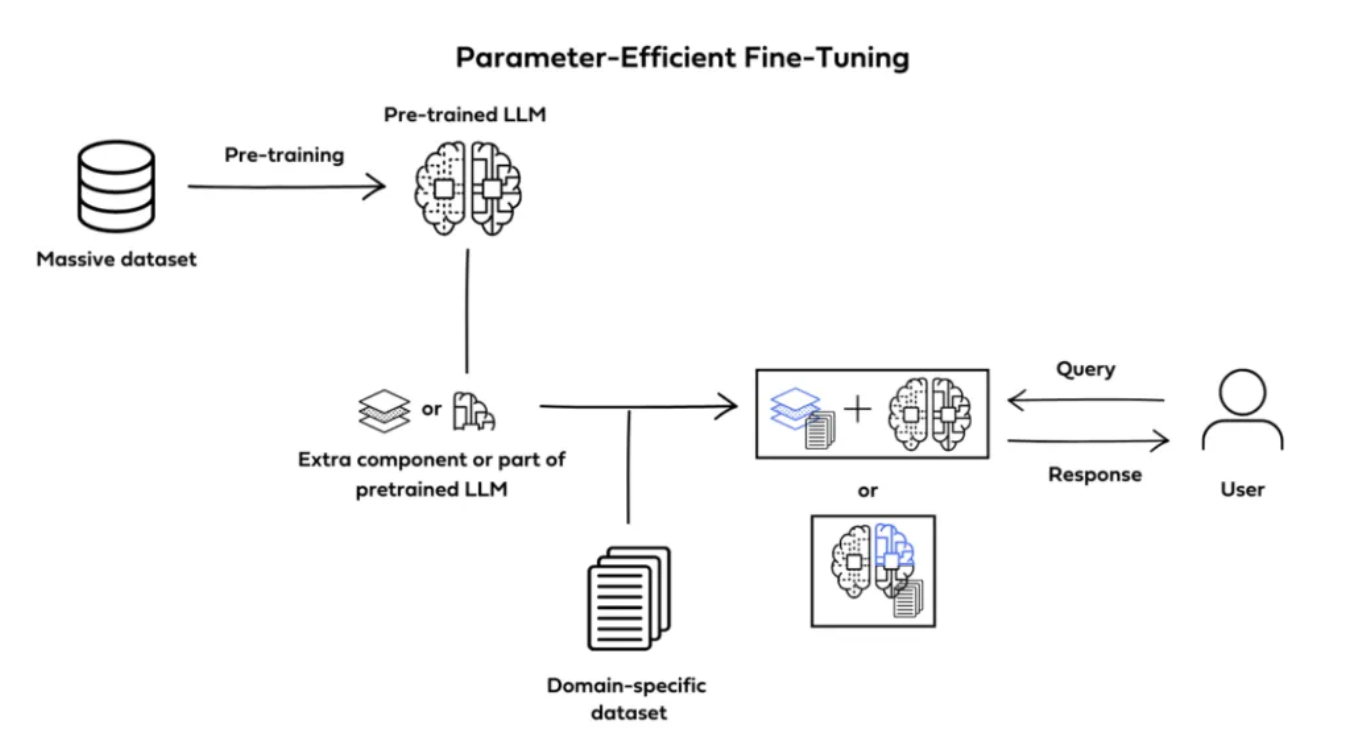

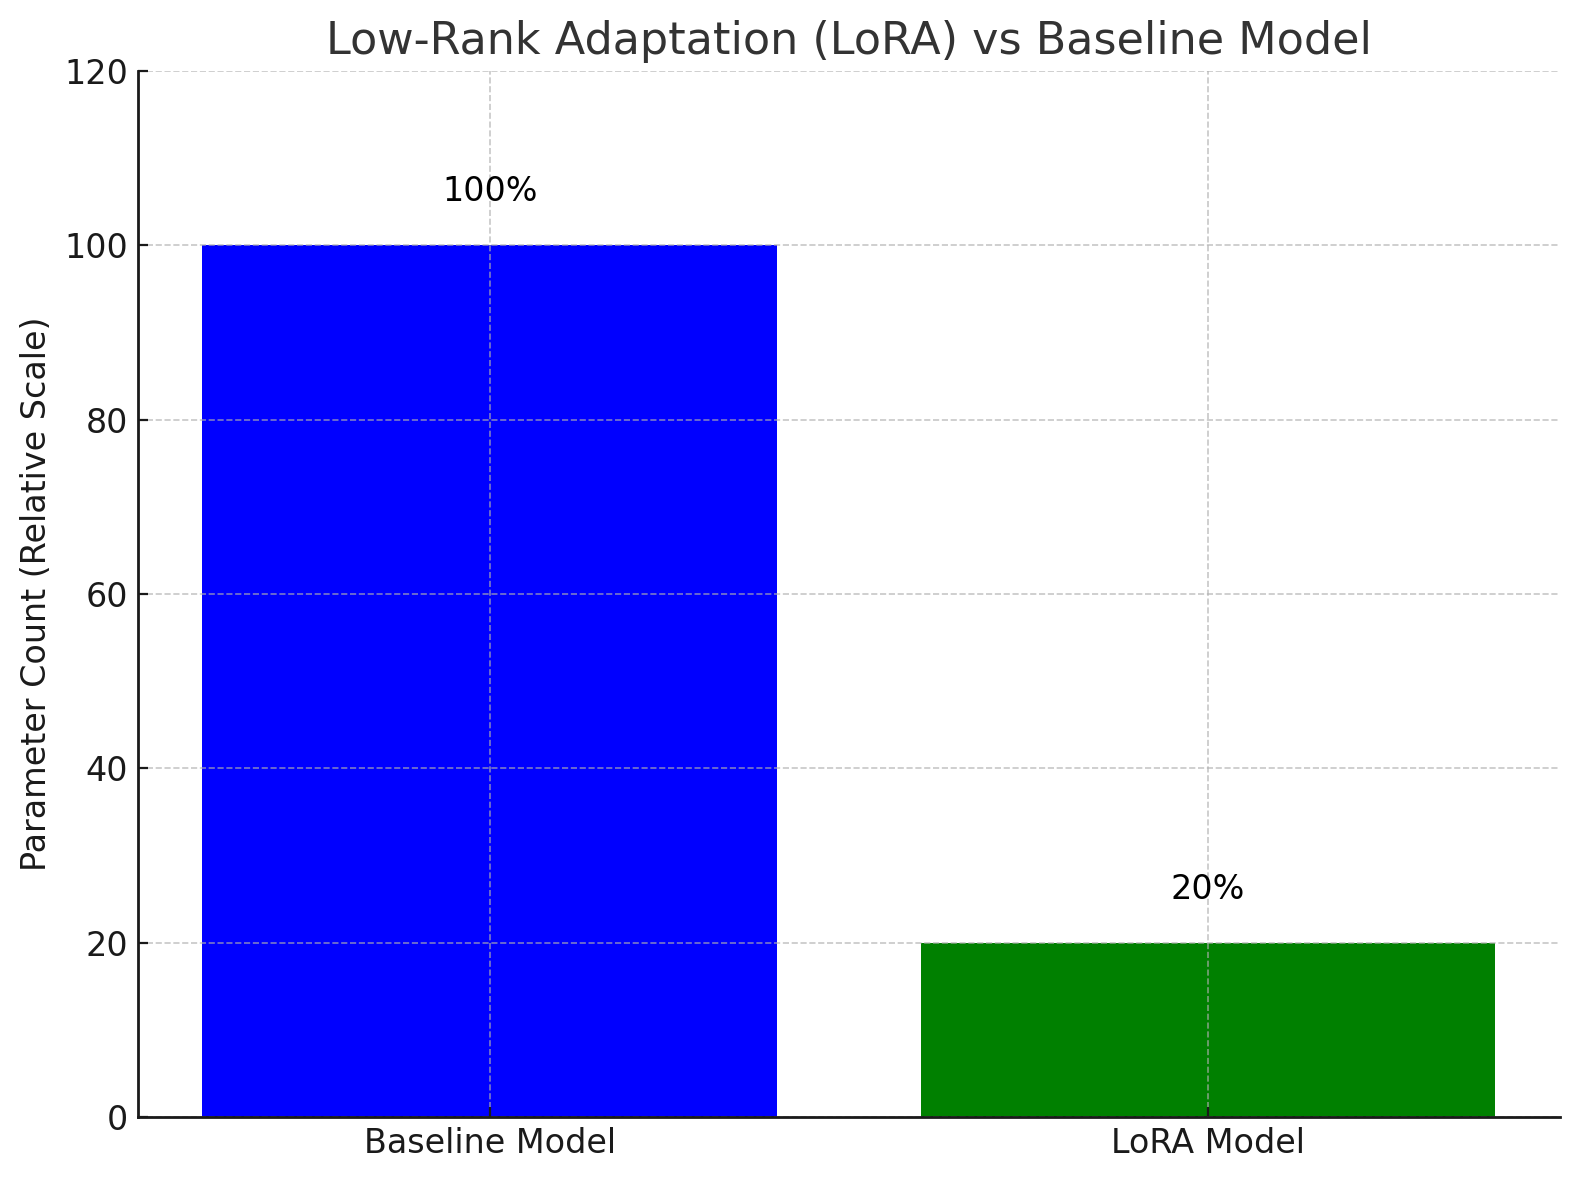

<a name='3.1'></a>
### 3.1 - Setup the PEFT/LoRA model for Fine-Tuning

We need to set up the PEFT/LoRA model for fine-tuning with a new layer/parameter adapter. Using PEFT/LoRA, you are freezing the underlying LLM and only training the adapter. Have a look at the LoRA configuration below. Note the rank (`r`) hyper-parameter, which defines the rank/dimension of the adapter to be trained.

In [32]:
from peft import LoraConfig, get_peft_model, TaskType

lora_config = LoraConfig(
    r=32, # Rank
    lora_alpha=32,
    target_modules=["q", "v"],
    lora_dropout=0.05,
    bias="none",
    task_type=TaskType.SEQ_2_SEQ_LM # FLAN-T5
)

Add LoRA adapter layers/parameters to the original LLM to be trained.

In [33]:
peft_model = get_peft_model(original_model,
                            lora_config)
print(print_number_of_trainable_model_parameters(peft_model))

trainable model parameters: 3538944
all model parameters: 251116800
percentage of trainable model parameters: 1.41%


<a name='3.2'></a>
### 3.2 - Training PEFT Adapter

Define training arguments and create `Trainer` instance.

In [34]:
output_dir = f'./peft-dialogue-summary-training-{str(int(time.time()))}'

peft_training_args = TrainingArguments(
    output_dir=output_dir,
    auto_find_batch_size=True,
    learning_rate=1e-3, # Higher learning rate than full fine-tuning.
    num_train_epochs=1000,
    logging_steps=5,
    max_steps=1000
)

peft_trainer = Trainer(
    model=peft_model,
    args=peft_training_args,
    train_dataset=tokenized_datasets["train"],
)

Now everything is ready to train the PEFT adapter and save the model.



In [35]:
peft_trainer.train()

peft_model_path="./peft-dialogue-summary-checkpoint-local"

peft_trainer.model.save_pretrained(peft_model_path)
tokenizer.save_pretrained(peft_model_path)

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss
5,31.150000
10,18.337500
15,5.731300
20,4.693700
25,4.146900
30,3.459400
35,2.493700
40,1.671900
45,1.024200
50,0.753900


('./peft-dialogue-summary-checkpoint-local/tokenizer_config.json',
 './peft-dialogue-summary-checkpoint-local/special_tokens_map.json',
 './peft-dialogue-summary-checkpoint-local/spiece.model',
 './peft-dialogue-summary-checkpoint-local/added_tokens.json',
 './peft-dialogue-summary-checkpoint-local/tokenizer.json')

Check that the size of this model is much less than the original LLM:

We have prepared this model by adding an adapter to the original FLAN-T5 model. We are setting `is_trainable=False` because the plan is only to perform inference with this PEFT model. If we were preparing the model for further training, you would set `is_trainable=True`.

In [36]:
from peft import PeftModel, PeftConfig

peft_model_base = AutoModelForSeq2SeqLM.from_pretrained("google/flan-t5-base", torch_dtype=torch.bfloat16)
tokenizer = AutoTokenizer.from_pretrained("google/flan-t5-base")

peft_model = PeftModel.from_pretrained(peft_model_base,
                                       './peft-dialogue-summary-checkpoint-local/',
                                       torch_dtype=torch.bfloat16,
                                       is_trainable=False)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:797: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


The number of trainable parameters will be `0` due to `is_trainable=False` setting:

In [37]:
print(print_number_of_trainable_model_parameters(peft_model))

trainable model parameters: 0
all model parameters: 251116800
percentage of trainable model parameters: 0.00%


<a name='3.3'></a>
### 3.3 - Evaluate the Model Qualitatively (Human Evaluation)

Make inferences for the same example as in sections [1.3](#1.3) and [2.3](#2.3), with the original model, fully fine-tuned and PEFT model.

In [39]:
index = 200
dialogue = dataset['test'][index]['dialogue']
human_baseline_summary = dataset['test'][index]['summary']

prompt = f"""
Summarize the following conversation.

{dialogue}

Summary: """

input_ids = tokenizer(prompt, return_tensors="pt").input_ids.to(original_model.device)

original_model_outputs = original_model.generate(input_ids=input_ids, generation_config=GenerationConfig(max_new_tokens=200, num_beams=1))
original_model_text_output = tokenizer.decode(original_model_outputs[0], skip_special_tokens=True)

instruct_model_outputs = instruct_model.generate(input_ids=input_ids.to(instruct_model.device), generation_config=GenerationConfig(max_new_tokens=200, num_beams=1))
instruct_model_text_output = tokenizer.decode(instruct_model_outputs[0], skip_special_tokens=True)

peft_model_outputs = peft_model.generate(input_ids=input_ids.to(peft_model.device), generation_config=GenerationConfig(max_new_tokens=200, num_beams=1))
peft_model_text_output = tokenizer.decode(peft_model_outputs[0], skip_special_tokens=True)

print(dash_line)
print(f'BASELINE HUMAN SUMMARY:\n{human_baseline_summary}')
print(dash_line)
print(f'ORIGINAL MODEL:\n{original_model_text_output}')
print(dash_line)
print(f'INSTRUCT MODEL:\n{instruct_model_text_output}')
print(dash_line)
print(f'PEFT MODEL: {peft_model_text_output}')

---------------------------------------------------------------------------------------------------
BASELINE HUMAN SUMMARY:
#Person1# teaches #Person2# how to upgrade software and hardware in #Person2#'s system.
---------------------------------------------------------------------------------------------------
ORIGINAL MODEL:
#Person1# recommends #Person2# to upgrade #Person2#'s system. #Person2# recommends a more powerful processor, more memory and a faster modem.
---------------------------------------------------------------------------------------------------
INSTRUCT MODEL:
You might want to upgrade your computer.
---------------------------------------------------------------------------------------------------
PEFT MODEL: #Person2# wants to upgrade his system and upgrade his hardware. #Person1# suggests adding a painting program to his software and adding a CD-ROM drive.


<a name='3.4'></a>
###  Evaluate the Model Quantitatively (with ROUGE Metric)
Performing inferences for the sample of the test dataset (only 10 dialogues and summaries to save time).

In [41]:
dialogues = dataset['test'][0:10]['dialogue']
human_baseline_summaries = dataset['test'][0:10]['summary']

original_model_summaries = []
instruct_model_summaries = []
peft_model_summaries = []

for idx, dialogue in enumerate(dialogues):
    prompt = f"""
Summarize the following conversation.

{dialogue}

Summary: """

    input_ids = tokenizer(prompt, return_tensors="pt").input_ids

    human_baseline_text_output = human_baseline_summaries[idx]

    original_model_outputs = original_model.generate(input_ids=input_ids.to(original_model.device), generation_config=GenerationConfig(max_new_tokens=200))
    original_model_text_output = tokenizer.decode(original_model_outputs[0], skip_special_tokens=True)

    instruct_model_outputs = instruct_model.generate(input_ids=input_ids.to(instruct_model.device), generation_config=GenerationConfig(max_new_tokens=200))
    instruct_model_text_output = tokenizer.decode(instruct_model_outputs[0], skip_special_tokens=True)

    peft_model_outputs = peft_model.generate(input_ids=input_ids.to(peft_model.device), generation_config=GenerationConfig(max_new_tokens=200))
    peft_model_text_output = tokenizer.decode(peft_model_outputs[0], skip_special_tokens=True)

    original_model_summaries.append(original_model_text_output)
    instruct_model_summaries.append(instruct_model_text_output)
    peft_model_summaries.append(peft_model_text_output)

zipped_summaries = list(zip(human_baseline_summaries, original_model_summaries, instruct_model_summaries, peft_model_summaries))

df = pd.DataFrame(zipped_summaries, columns = ['human_baseline_summaries', 'original_model_summaries', 'instruct_model_summaries', 'peft_model_summaries'])
df

,human_baseline_summaries,original_model_summaries,instruct_model_summaries,peft_model_summaries
0,Ms. Dawson helps #Person1# to write a memo to ...,#Person1# asks #Person2# to take a dictation t...,This memo is to be distributed to all employee...,Ms. Dawson asks Ms. Dawson to take a dictation...
1,In order to prevent employees from wasting tim...,#Person1# asks #Person2# to take a dictation f...,This memo is to be distributed to all employee...,Ms. Dawson asks Ms. Dawson to take a dictation...
2,Ms. Dawson takes a dictation for #Person1# abo...,Ms. Dawson asks Ms. Dawson to take a dictation...,This memo is to be distributed to all employee...,Ms. Dawson asks Ms. Dawson to take a dictation...
3,#Person2# arrives late because of traffic jam....,#Person2# got stuck in traffic and got stuck i...,Taking public transport to work is a good idea.,#Person2# got stuck in traffic and got stuck i...
4,#Person2# decides to follow #Person1#'s sugges...,#Person2# is getting stuck in traffic again. #...,Taking public transport to work is a good idea.,#Person2# got stuck in traffic and got stuck i...
5,#Person2# complains to #Person1# about the tra...,#Person1# thinks it's a good idea to try to fi...,Taking public transport to work is a good idea.,#Person2# got stuck in traffic and got stuck i...
6,#Person1# tells Kate that Masha and Hero get d...,#Person2# tells #Person1# Masa and Hero are ge...,Masha and Hero are getting divorced.,Kate tells #Person1# that Masha and Hero are g...
7,#Person1# tells Kate that Masha and Hero are g...,#Person1# and Kate tell each other that Masha ...,Masha and Hero are getting divorced.,Kate tells #Person1# that Masha and Hero are g...
8,#Person1# and Kate talk about the divorce betw...,#Person1# tells #Person2# that Masha and Hero ...,Masha and Hero are getting divorced.,Kate tells #Person1# that Masha and Hero are g...
9,#Person1# and Brian are at the birthday party ...,Brian remembers his birthday and wants to have...,Brian's birthday is coming up.,Brian's birthday is coming soon. Brian invites...


In [42]:
rouge = evaluate.load('rouge')

original_model_results = rouge.compute(
    predictions=original_model_summaries,
    references=human_baseline_summaries[0:len(original_model_summaries)],
    use_aggregator=True,
    use_stemmer=True,
)

instruct_model_results = rouge.compute(
    predictions=instruct_model_summaries,
    references=human_baseline_summaries[0:len(instruct_model_summaries)],
    use_aggregator=True,
    use_stemmer=True,
)

peft_model_results = rouge.compute(
    predictions=peft_model_summaries,
    references=human_baseline_summaries[0:len(peft_model_summaries)],
    use_aggregator=True,
    use_stemmer=True,
)

print('ORIGINAL MODEL:')
print(original_model_results)
print('INSTRUCT MODEL:')
print(instruct_model_results)
print('PEFT MODEL:')
print(peft_model_results)

ORIGINAL MODEL:
{'rouge1': 0.37817772303429387, 'rouge2': 0.13031470336137677, 'rougeL': 0.29972545883341895, 'rougeLsum': 0.2989283573841436}
INSTRUCT MODEL:
{'rouge1': 0.28647748040489973, 'rouge2': 0.13497482028216662, 'rougeL': 0.23619027925479535, 'rougeLsum': 0.23930701616185485}
PEFT MODEL:
{'rouge1': 0.3932262580868263, 'rouge2': 0.11719878788018051, 'rougeL': 0.2807225581685594, 'rougeLsum': 0.2822069597841921}


Notice, that PEFT model results are not too bad, while the training process was much easier!

You already computed ROUGE score on the full dataset, after loading the results from the `data/dialogue-summary-training-results.csv` file. Load the values for the PEFT model now and check its performance compared to other models.

In [46]:
"""
human_baseline_summaries = results['human_baseline_summaries'].values
original_model_summaries = results['original_model_summaries'].values
instruct_model_summaries = results['instruct_model_summaries'].values
peft_model_summaries     = results['peft_model_summaries'].values

original_model_results = rouge.compute(
    predictions=original_model_summaries,
    references=human_baseline_summaries[0:len(original_model_summaries)],
    use_aggregator=True,
    use_stemmer=True,
)

instruct_model_results = rouge.compute(
    predictions=instruct_model_summaries,
    references=human_baseline_summaries[0:len(instruct_model_summaries)],
    use_aggregator=True,
    use_stemmer=True,
)

peft_model_results = rouge.compute(
    predictions=peft_model_summaries,
    references=human_baseline_summaries[0:len(peft_model_summaries)],
    use_aggregator=True,
    use_stemmer=True,
)

print('ORIGINAL MODEL:')
print(original_model_results)
print('INSTRUCT MODEL:')
print(instruct_model_results)
print('PEFT MODEL:')
print(peft_model_results)

"""

"\nhuman_baseline_summaries = results['human_baseline_summaries'].values\noriginal_model_summaries = results['original_model_summaries'].values\ninstruct_model_summaries = results['instruct_model_summaries'].values\npeft_model_summaries     = results['peft_model_summaries'].values\n\noriginal_model_results = rouge.compute(\n    predictions=original_model_summaries,\n    references=human_baseline_summaries[0:len(original_model_summaries)],\n    use_aggregator=True,\n    use_stemmer=True,\n)\n\ninstruct_model_results = rouge.compute(\n    predictions=instruct_model_summaries,\n    references=human_baseline_summaries[0:len(instruct_model_summaries)],\n    use_aggregator=True,\n    use_stemmer=True,\n)\n\npeft_model_results = rouge.compute(\n    predictions=peft_model_summaries,\n    references=human_baseline_summaries[0:len(peft_model_summaries)],\n    use_aggregator=True,\n    use_stemmer=True,\n)\n\nprint('ORIGINAL MODEL:')\nprint(original_model_results)\nprint('INSTRUCT MODEL:')\nprint

The results show less of an improvement over full fine-tuning, but the benefits of PEFT typically outweigh the slightly-lower performance metrics.

Calculate the improvement of PEFT over the original model:

In [44]:
print("Absolute percentage improvement of PEFT MODEL over ORIGINAL MODEL")

improvement = (np.array(list(peft_model_results.values())) - np.array(list(original_model_results.values())))
for key, value in zip(peft_model_results.keys(), improvement):
    print(f'{key}: {value*100:.2f}%')

Absolute percentage improvement of PEFT MODEL over ORIGINAL MODEL
rouge1: 1.50%
rouge2: -1.31%
rougeL: -1.90%
rougeLsum: -1.67%


Now calculate the improvement of PEFT over a full fine-tuned model:

In [45]:
print("Absolute percentage improvement of PEFT MODEL over INSTRUCT MODEL")

improvement = (np.array(list(peft_model_results.values())) - np.array(list(instruct_model_results.values())))
for key, value in zip(peft_model_results.keys(), improvement):
    print(f'{key}: {value*100:.2f}%')

Absolute percentage improvement of PEFT MODEL over INSTRUCT MODEL
rouge1: 10.67%
rouge2: -1.78%
rougeL: 4.45%
rougeLsum: 4.29%


Here you see a small percentage decrease in the ROUGE metrics vs. full fine-tuned. However, the training requires much less computing and memory resources (often just a single GPU).